导入数据

In [32]:
# Import necessary libraries
from matplotlib import pyplot as plt
from scripts.dataAcquisition.md_dataPreparation import get_md_data
import lightgbm as lgb
import numpy as np
import pandas as pd
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [19]:
'''****************************数据获取与预处理****************************'''
# 获取已处理的数据集，完成最终模型训练与测试验证，
data_path = 'F:\\MDDTI_YYL\\Data'
datafiles = ['KIBA_md.csv', 'BindingDBIC50_md.csv', 'Lenselink_md.csv']
all_drug_encoder = ['ECFP', 'RDKit', 'MolBert']
all_target_encoder = ['Glove', 'SeqVec', 'UniRep']
dataset = datafiles[1]
data_name = dataset.split(".")[0][:-3]
drug_encoder = all_drug_encoder[1]
target_encoder = all_target_encoder[1]

X_train, X_val, X_test, y_train, y_val, y_test = get_md_data(dataset=dataset, drug_encoder=drug_encoder, target_encoder=target_encoder)


def y_count(y_raw):
    return np.median(y_raw), np.mean(y_raw), np.max(y_raw), np.min(y_raw)

print(y_count(y_val), y_count(y_test))

BIOACTIVITY_THRESHOLD = {
    'KIBA': 12.1,
    'Lenselink': 6.5,
    'BindingDBIC50': 6
}

# y_train = (y_train > BIOACTIVITY_THRESHOLD[data_name])
# y_val = (y_val > BIOACTIVITY_THRESHOLD[data_name])
# y_test = (y_test > BIOACTIVITY_THRESHOLD[data_name])

(5.296700022075754, 5.6467387406657945, 9.452225294612177, 2.906578279814018) (5.178484367114523, 5.504830576972056, 9.853871964321762, 2.8860566142858968)


数据集标准化

In [20]:
# 将列表类型数据转换为DataFrame
y_train = pd.DataFrame(y_train)
y_val = pd.DataFrame(y_val)
y_test = pd.DataFrame(y_test)
X_train = pd.DataFrame(X_train)
X_val = pd.DataFrame(X_val)
X_test = pd.DataFrame(X_test)
# y按行拼接获取数字特征
y = pd.concat([y_train, y_val, y_test])
# 训练集数据求x的均值和标准差
# 全体y值求y的均值和标准差
x_mean = X_train.mean()
x_std = X_train.std()
y_mean = y.mean()
y_std = y.std()
X_train = (X_train - x_mean) / x_std
X_val = (X_val - x_mean) / x_std
X_test = (X_test - x_mean) / x_std
y_train = (y_train - y_mean) / y_std
y_val = (y_val - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

In [21]:
# 模型参数
param_lgb = {
    'learning_rate': 0.02,
    'boosting_type': 'gbdt',
    'objective': 'mse',
    'num_leaves': 127,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_freq': 4,
    'verbose': -1,
    'seed': 42
}
model_lgb = lgb.LGBMRegressor(**param_lgb)
model_lgb.fit(X_train, y_train, eval_metric='rmse')

LGBMRegressor(bagging_fraction=0.9, bagging_freq=4, feature_fraction=0.8,
              learning_rate=0.02, num_leaves=127, objective='mse', seed=42,
              verbose=-1)

已完成LightGBM回归模型的构建，接下来对预测结果进一步分析：
1、预测结果和真实值可视化

In [27]:
# 获取预测值
pred_train =pd.DataFrame(model_lgb.predict(X_train))
pred_val = pd.DataFrame(model_lgb.predict(X_val))
pred_test = pd.DataFrame(model_lgb.predict(X_test))

y_train_h = y_train*y_std+y_mean
pred_train_h = pred_train*y_std+y_mean

y_val_h = y_val*y_std+y_mean
pred_val_h = pred_val*y_std+y_mean

y_test_h = y_test*y_std+y_mean
pred_test_h = pred_test*y_std+y_mean

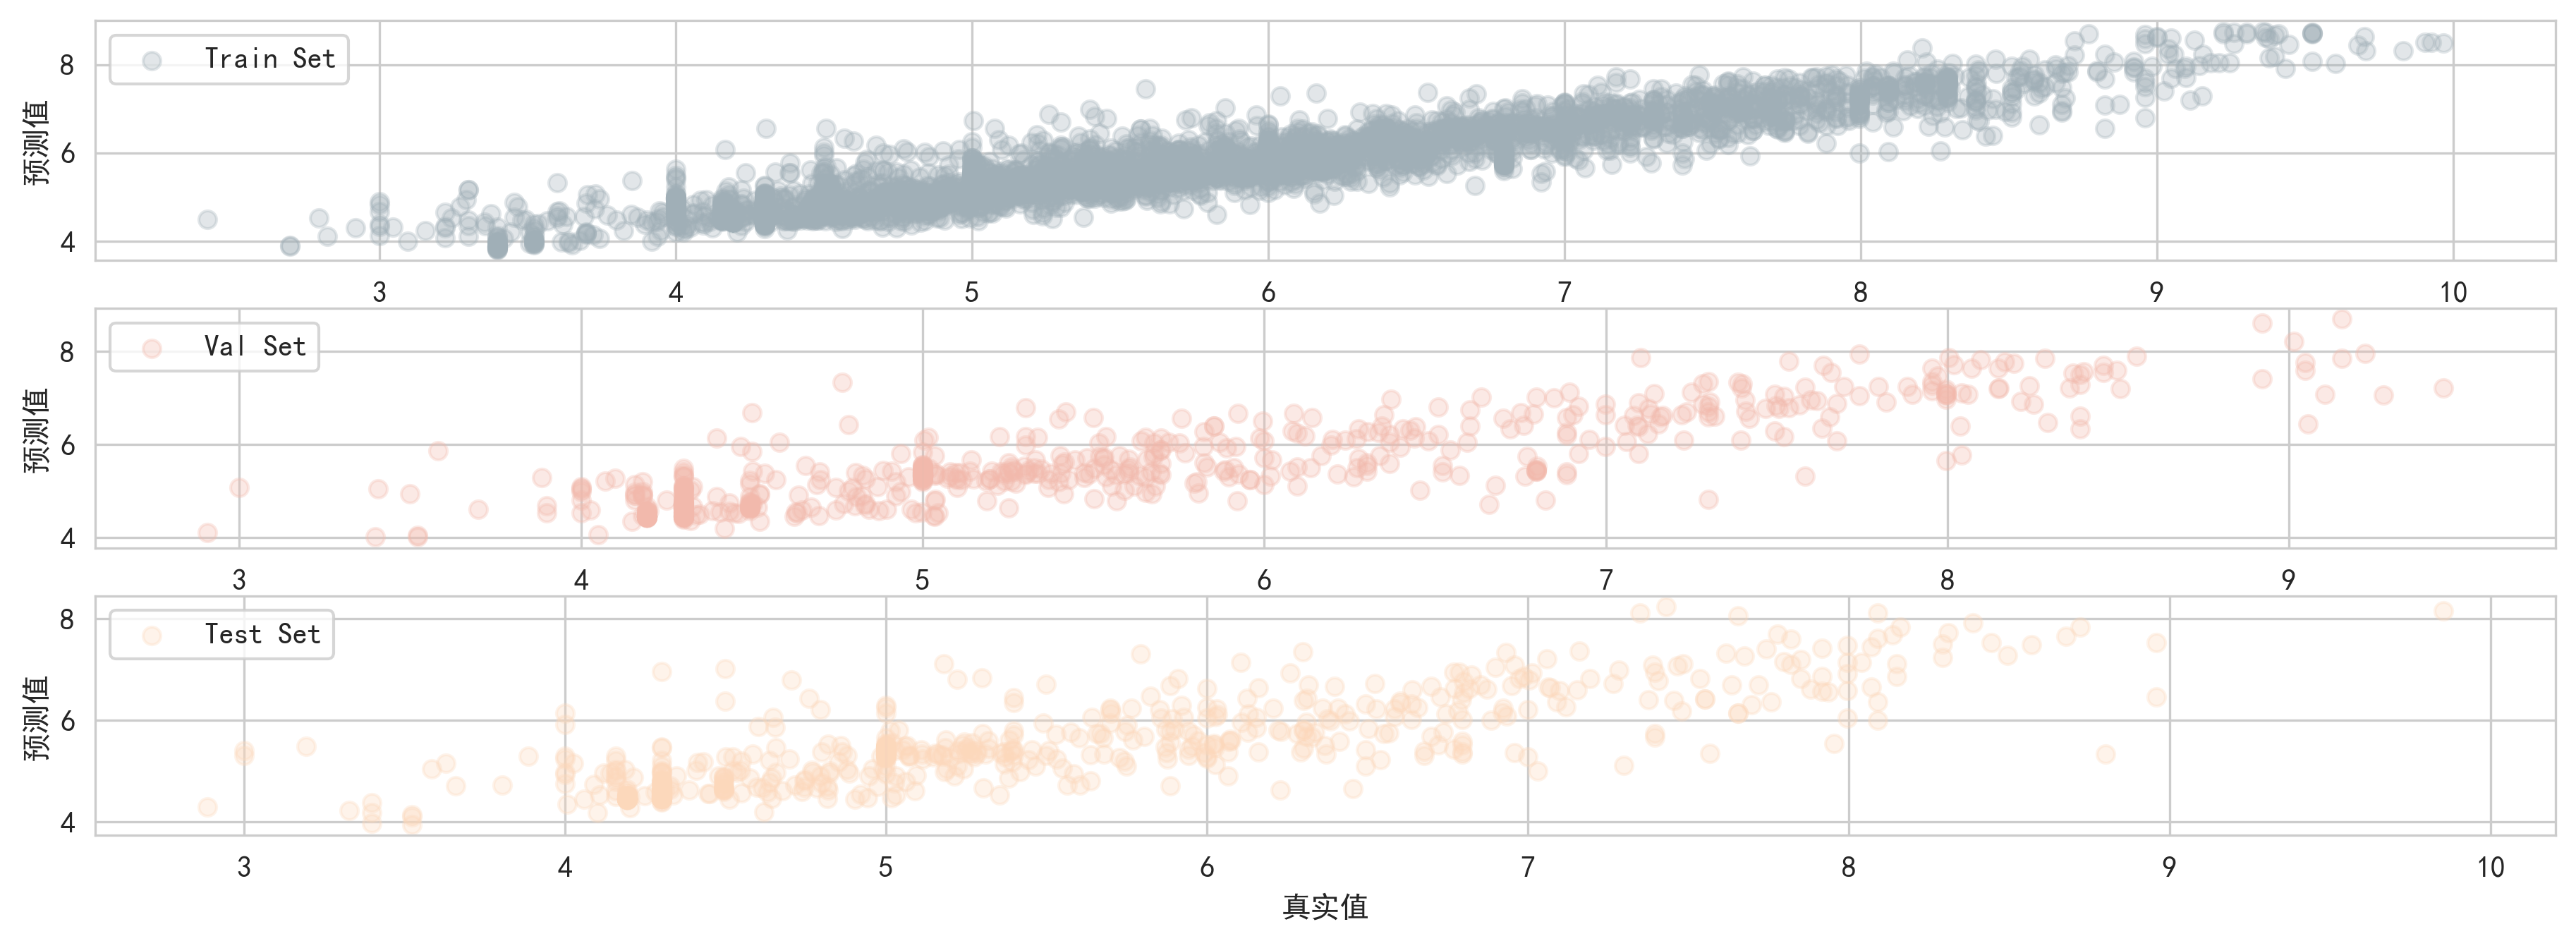

In [34]:
# 开始绘制
# import seaborn as sns
# colors = sns.color_palette("husl", 3)
# 定义画布
plt.figure(figsize=(15, 5), dpi=300)

# 分别绘制三个子图
plt.subplot(3, 1, 1)
plt.scatter(y_train_h, pred_train_h, color="#A0AFB7", label='Train Set', alpha=0.3)
plt.xlabel("真实值")
plt.ylabel("预测值")
plt.legend()
plt.subplot(3, 1, 2)
plt.scatter(y_val_h, pred_val_h, color="#F2B9AC", label='Val Set', alpha=0.3)
plt.xlabel("真实值")
plt.ylabel("预测值")
plt.legend()
plt.subplot(3, 1, 3)
plt.scatter(y_test_h, pred_test_h, color="#FCD8BB", label='Test Set', alpha=0.3)
plt.xlabel("真实值")
plt.ylabel("预测值")
plt.legend()
# plt.tight_layout()
plt.show()

2、shap绘制摘要图————————
参与模型预测的变量和药物分子以及靶标信息无法一一对应，故特征工程困难


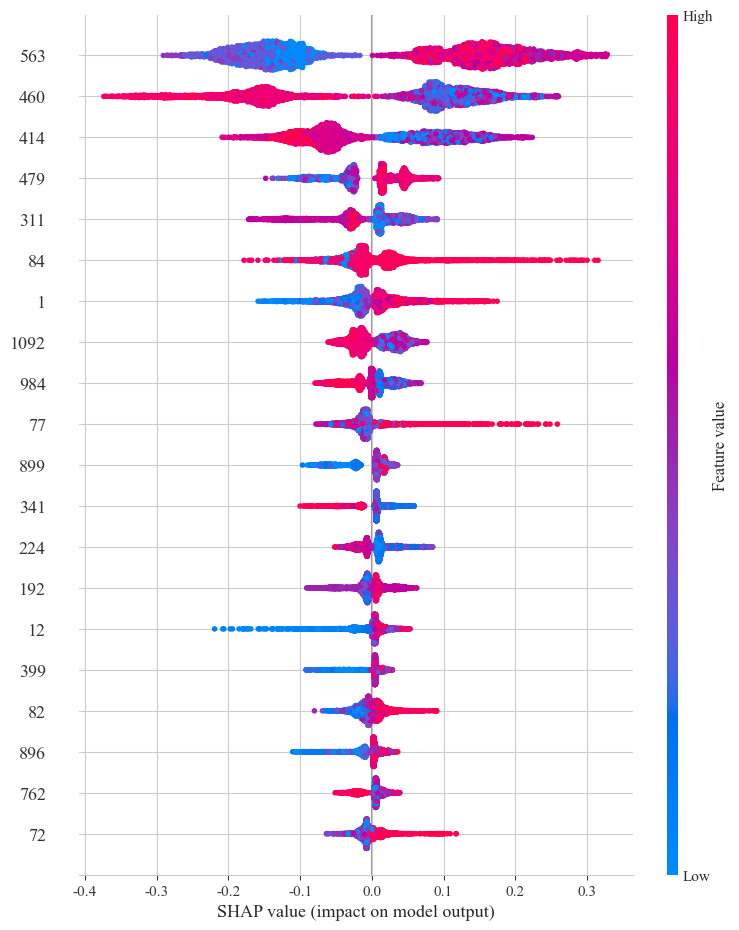

In [40]:
# 构建力图
import shap

explainer = shap.TreeExplainer(model_lgb)
# 计算shap值为numpy.array数组
shap_values = explainer.shap_values(X_train)
# 设置字体
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 13
plt.figure()
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, plot_type="dot")


3、对三个数据集展示每一个特征的排序-----每一个shap值和原始数据每一个点一一对应

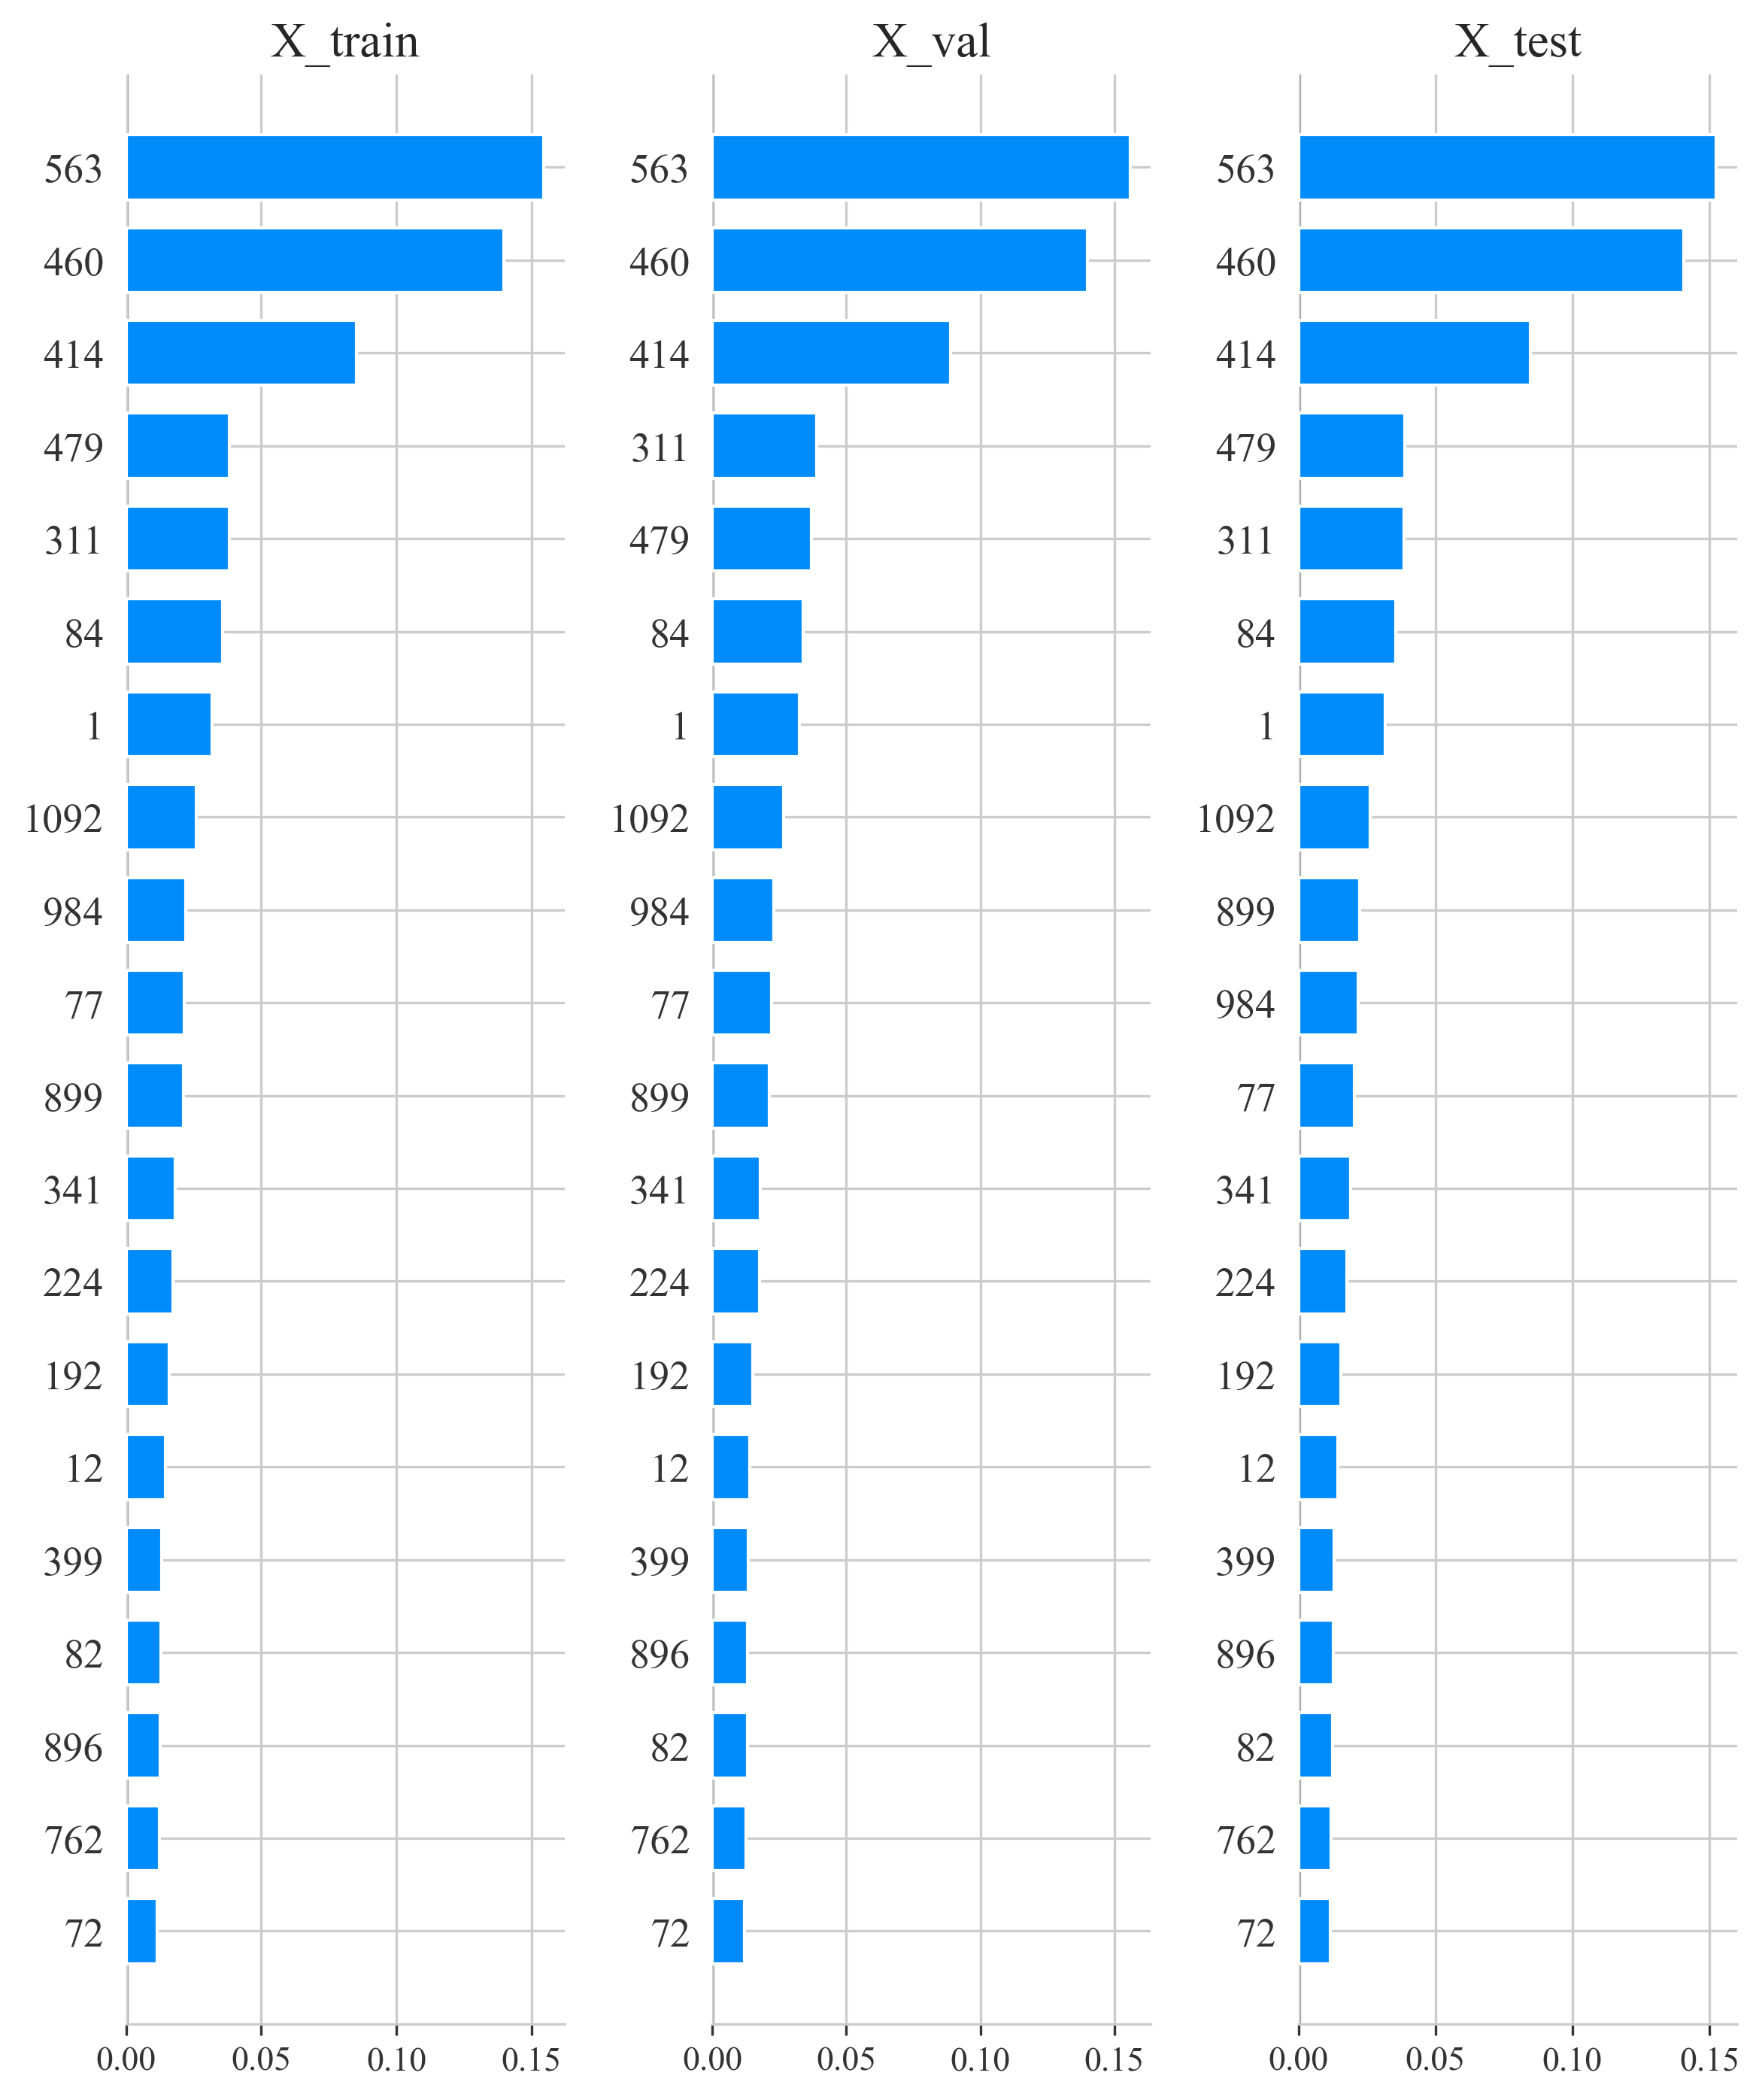

In [41]:
# 计算训练集和测试集的shap值
# shap_value样本取绝对值的平均值从而得到每个特征的重要程度？？？
shap_values_train = explainer.shap_values(X_train)
shap_values_val = explainer.shap_values(X_val)
shap_values_test = explainer.shap_values(X_test)

# 继续绘制shap总结图
plt.figure(figsize=(15, 5), dpi=300)
plt.subplot(1, 3, 1)
shap.summary_plot(shap_values_train, X_train, feature_names=X_train.columns, plot_type="bar", show=False)
plt.title("X_train")
plt.xlabel('')

plt.subplot(1, 3, 2)
shap.summary_plot(shap_values_val, X_val, feature_names=X_val.columns, plot_type="bar", show=False)
plt.title("X_val")
plt.xlabel('')

plt.subplot(1, 3, 3)
shap.summary_plot(shap_values_test, X_test, feature_names=X_test.columns, plot_type="bar", show=False)
plt.title("X_test")
plt.xlabel('')

plt.tight_layout()
plt.show()

4、依赖图：显示一个特征的shap值与该特征值之间的关系，并展示特征值之间的交互作用

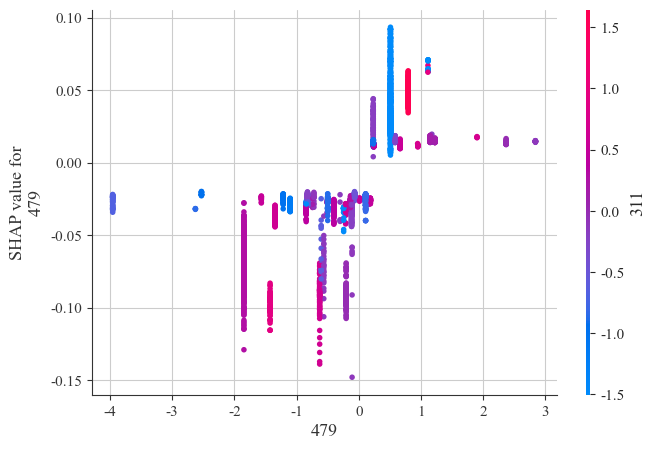

In [45]:
# shap.dependence_plot('欲研究的特证名', shap_values（通过shap计算得到的特征重要值）, X_train（训练数据）, interaction_index='460（与主特征交互的特征）')
# 若主特征值在3~6的范围内，shap变化并不明显，表明该特征对模型预测的目标变量影响并不大
shap.dependence_plot(479, shap_values, X_train, interaction_index=311)

5、力图：直观展示单个样本的shap值及其对模型预测结果的影响

In [56]:
# 基线值
# 特征贡献
# 预测值

plt.figure(figsize=(15, 5), dpi=300)
sample_index = 1
shap.force_plot(explainer.expected_value, shap_values_test[sample_index], X_test.iloc[sample_index], matplotlib=True)


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('float64'), dtype('<U3')) -> None

6、交互作用摘要图

In [58]:
shap_interaction_values = explainer.shap_interaction_values(X_val)
shap.summary_plot(shap_interaction_values, X_val)

TypeError: object of type 'int' has no len()

7、shap热图:有效探索和理解复杂模型的特征重要性和特征之间的相互关系，从而提高模型的可解释性

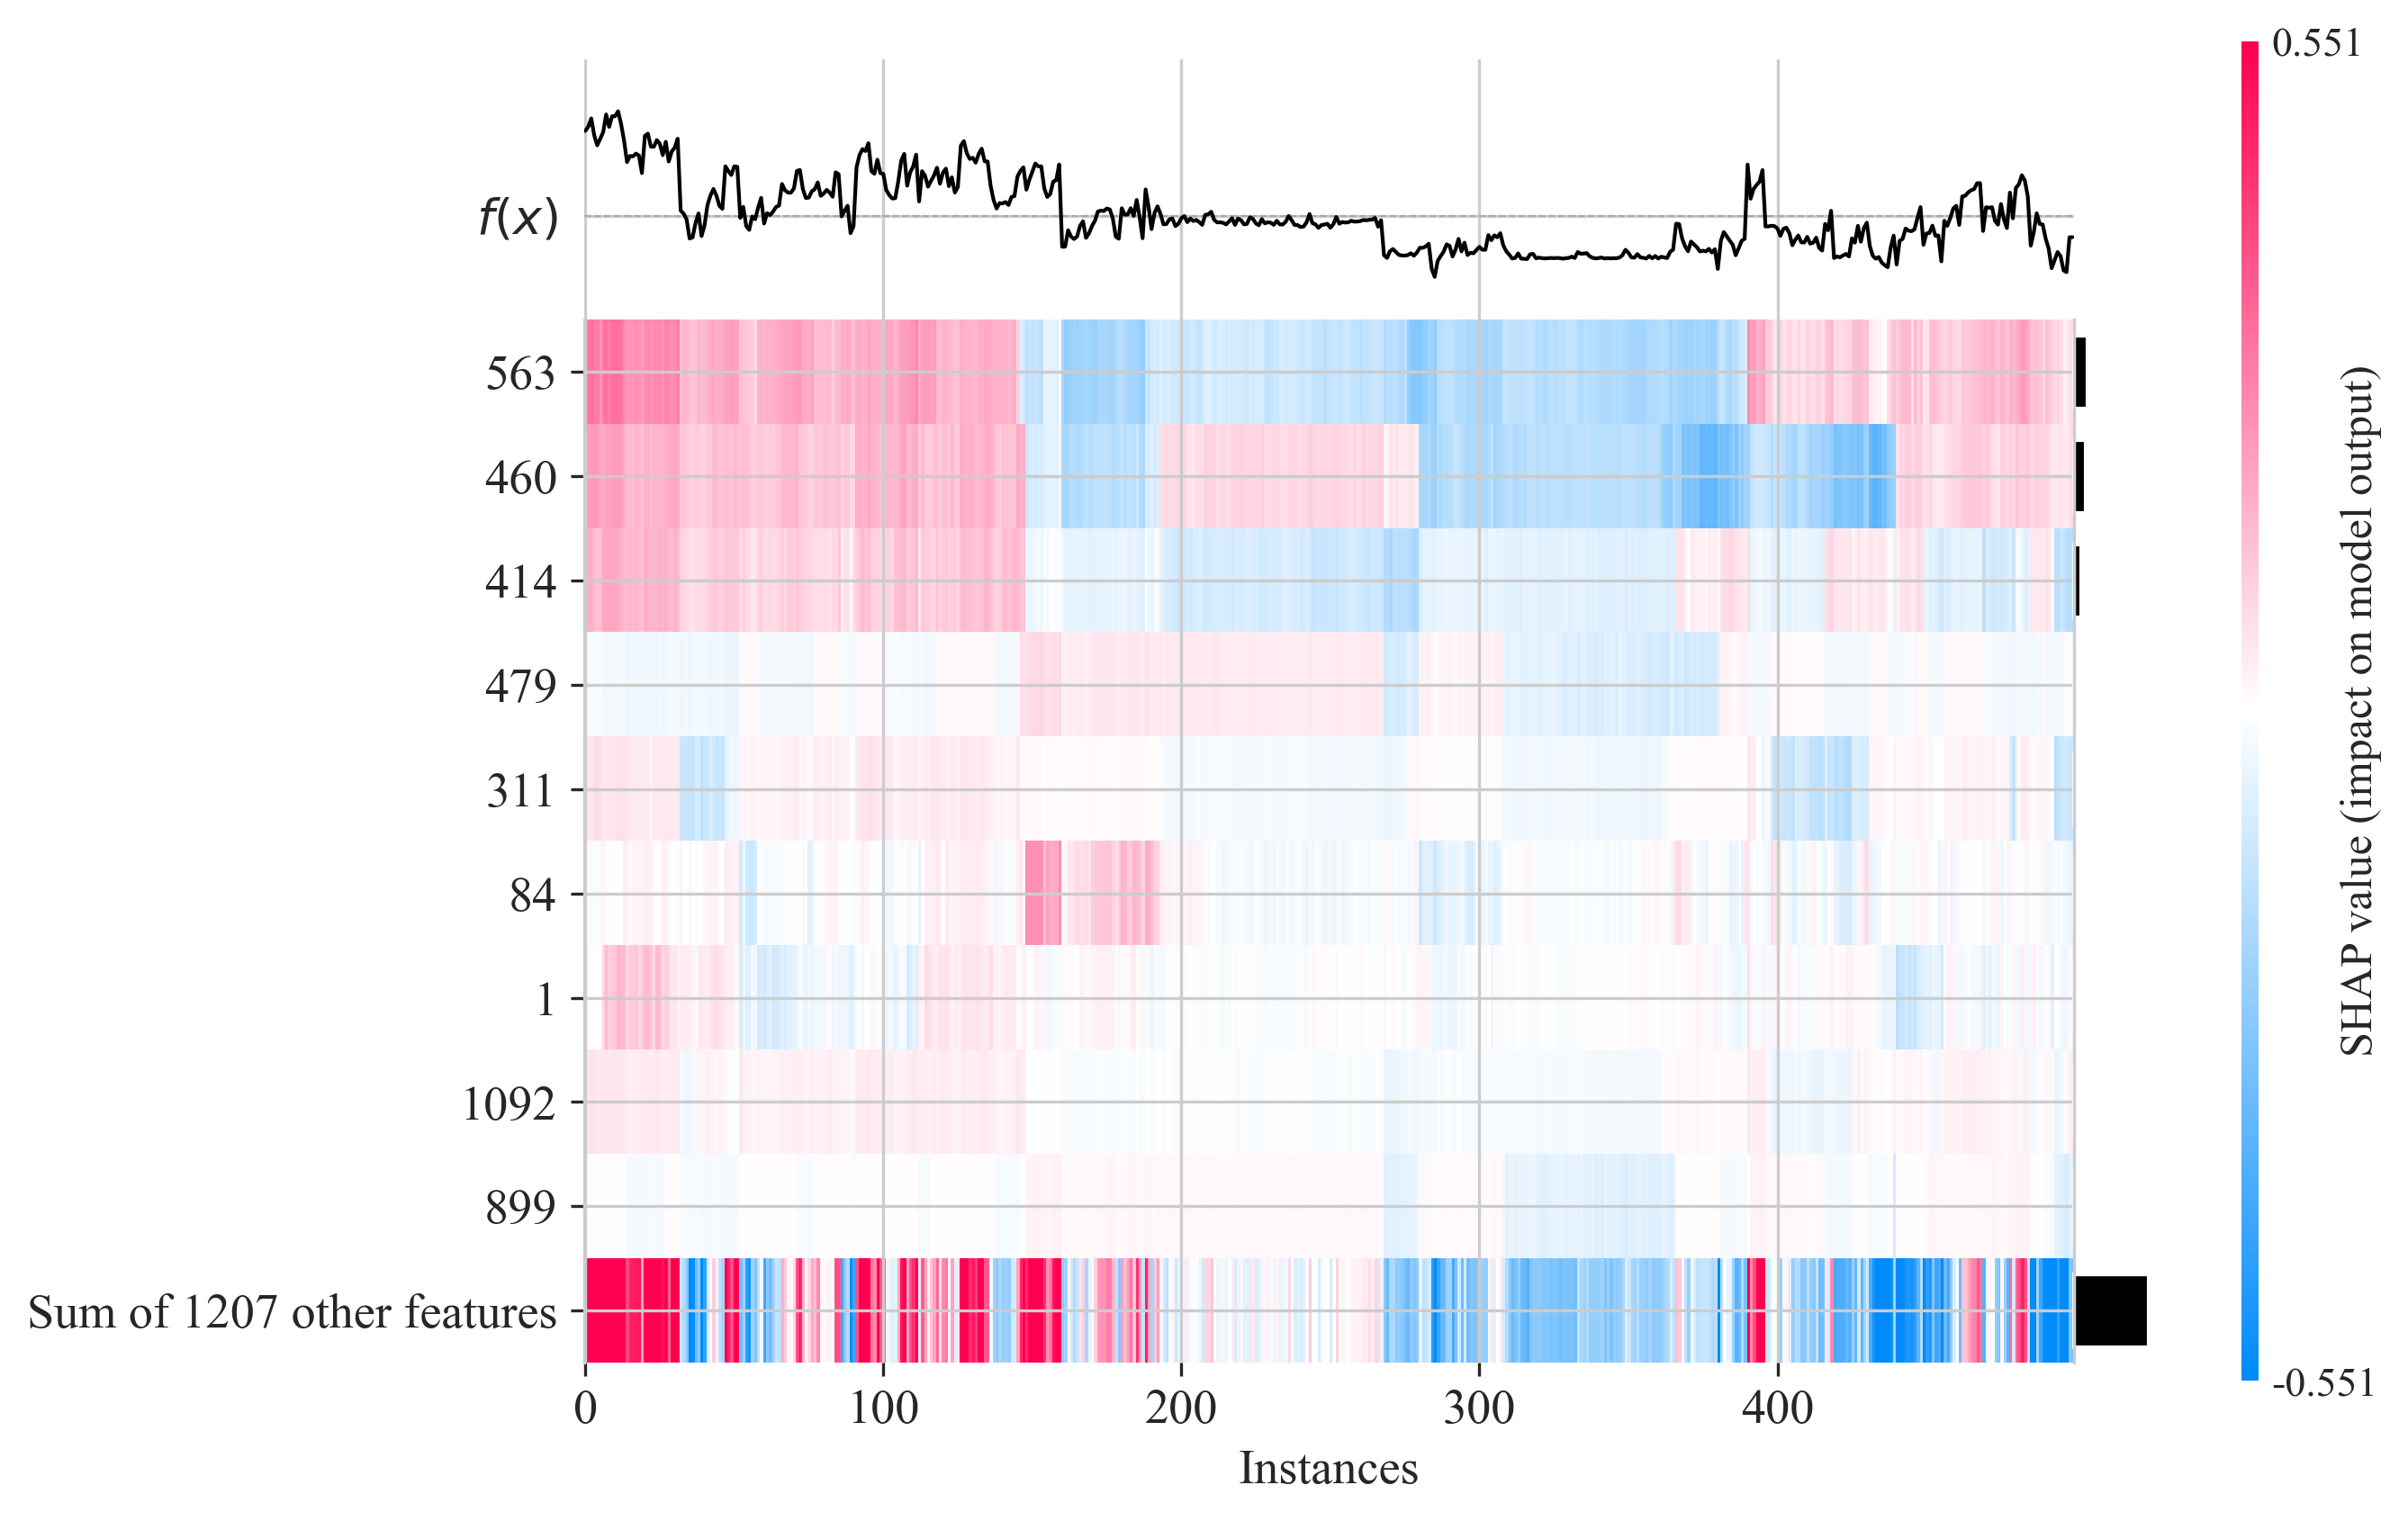

<Axes: xlabel='Instances'>

In [60]:
plt.figure(figsize=(15, 15), dpi=300)
shap_explanation = shap.Explanation(values=shap_values_test[0:500,:],base_values=explainer.expected_value,data=X_test.iloc[0:500,:],feature_names=X_test.columns)
shap.plots.heatmap(shap_explanation)